In [1]:
import pickle
import gzip
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pandas
from PIL import Image
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_mldata
from sklearn import datasets, svm, metrics
import math
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from keras.utils import np_utils
from scipy import stats

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def getBounds(index,batchsize,maxi):
    if((index+1)*batchsize>maxi):
        return index*batchsize,maxi
    else:
        return index*batchsize,(index+1)*batchsize

In [3]:
def softmax(W,x):
    v = np.dot(x,W.T)
    s = np.exp(v)
    y = s.T/np.sum(s,axis=1)
    return y.T

In [4]:
def predict(W,x):
    y=softmax(W,x);
    return y;

In [5]:
def negativeLogLoss(y,t):
    return -np.mean(np.sum(t * np.log(y) +(1 - t) * np.log(1 - y), axis=1))

In [6]:
def Accuracy(y,t):
    correct = 0
    for i in range(len(y)):
        if(np.argmax(y[i])==np.argmax(t[i])):
            correct+=1
    return correct/len(y)

# Preprocessing of MNIST and USPS Data

In [7]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [8]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            # resize image to match MNIST data features
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)
            

In [9]:
USPSMat = np.array(USPSMat)
USPSTar = np.array(USPSTar)

In [10]:
X_train, y_train = np.array(training_data[0]),np.array(training_data[1])
X_val, y_val = np.array(validation_data[0]),np.array(validation_data[1])
X_test, y_test = np.array(test_data[0]),np.array(test_data[1])
print(X_train.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)


In [11]:
# one hot encoding of target values
TrainingLabels = np_utils.to_categorical(training_data[1])
TestingLabels = np_utils.to_categorical(test_data[1])
ValidationLabels = np_utils.to_categorical(validation_data[1])
print(TrainingLabels.shape)
print(ValidationLabels.shape)
print(TestingLabels.shape)

(50000, 10)
(10000, 10)
(10000, 10)


In [12]:
MnistData = np.concatenate([training_data[0] , test_data[0] , validation_data[0]])
print(MnistData.shape)

X_Training = MnistData[:50000]
X_Val = MnistData[60000:70000]
X_Test = MnistData[50000:60000]
print(X_Training.shape)
print(X_Val.shape)
print(X_Test.shape)

(70000, 784)
(50000, 784)
(10000, 784)
(10000, 784)


# Logistic Regression

In [13]:
# Batch Gradient Descent 
BatchSize = 500
epochs = 50
lr = 0.01
W = np.ones((len(TrainingLabels[0]),len(X_Training[0])))
print(W.shape)

L_LogLoss_Val   = []
L_LogLoss_TR    = []
L_LogLoss_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
for i in range(epochs):
    for i in range(int(len(TrainingLabels)/BatchSize)):
        lower,upper   = getBounds(i,BatchSize,len(TrainingLabels))
        x = X_Training[lower:upper]
        T = TrainingLabels[lower:upper]
        y_cap = predict(W,x)
        y_cap_a = y_cap - T
        Delta_E = y_cap_a[:,:,None]*x[:,None,:]
        Delta_E_mean = np.mean(Delta_E,axis=0)
        Delta_W = -np.dot(lr,Delta_E_mean)
        W_next = W + Delta_W
        W = W_next
        
        # calculating error and accuracy during the learning process
        #-----------------TrainingData Accuracy---------------------#
        y_tr_l = predict(W,x)
        LogLoss_TR   =   negativeLogLoss(y_tr_l,T) 
        L_LogLoss_TR.append(LogLoss_TR)
        L_Acc_TR.append(Accuracy(y_tr_l,T))
        
        #-----------------ValidationData Accuracy---------------------#
        y_val_l = predict(W,X_Val)        
        LogLoss_Val   =   negativeLogLoss(y_val_l,ValidationLabels) 
        L_LogLoss_Val.append(LogLoss_Val)
        L_Acc_Val.append(Accuracy(y_val_l,ValidationLabels))
        
        #-----------------TestingData Accuracy---------------------#
        y_test_l = predict(W,X_Test) 
        LogLoss_Test   =   negativeLogLoss(y_test_l,TestingLabels) 
        L_LogLoss_Test.append(LogLoss_Test)
        L_Acc_Test.append(Accuracy(y_test_l,TestingLabels))


(10, 784)


In [14]:
print ("LogLoss Training   = " + str(np.around(min(L_LogLoss_TR),5)))
print ("LogLoss Validation = " + str(np.around(min(L_LogLoss_Val),5)))
print ("LogLoss Testing    = " + str(np.around(min(L_LogLoss_Test),5)))
print ("Accuracy Training   = " + str(np.around(max(L_Acc_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_Acc_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_Acc_Test),5)))

LogLoss Training   = 0.50747
LogLoss Validation = 0.6171
LogLoss Testing    = 0.63616
Accuracy Training   = 0.938
Accuracy Validation = 0.9046
Accuracy Testing    = 0.9012


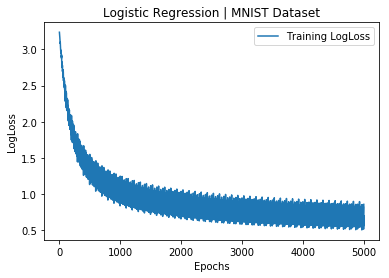

In [15]:
i = [j for j in range(5000)]
plt.figure(1)               
ax = plt.subplot(111)
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
ax.plot(i, L_LogLoss_TR,label ='Training LogLoss')
ax.legend()
plt.title('Logistic Regression | MNIST Dataset')
plt.show()

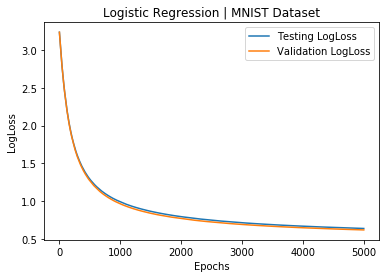

In [16]:
i = [j for j in range(5000)]
plt.figure(1)               
ax = plt.subplot(111)
ax.plot(i, L_LogLoss_Test,label ='Testing LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Epochs')       
ax.plot(i, L_LogLoss_Val,label ='Validation LogLoss')
ax.legend()
plt.title('Logistic Regression | MNIST Dataset')
plt.show()

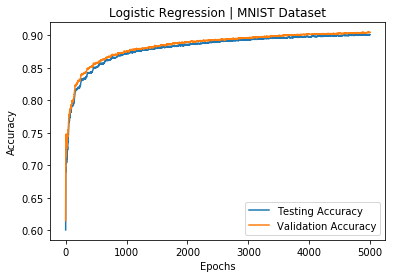

In [17]:
i = [j for j in range(5000)]
plt.figure(1)               
ax = plt.subplot(111)
ax.plot(i, L_Acc_Test[:5000],label ='Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')       
ax.plot(i, L_Acc_Val[:5000],label ='Validation Accuracy')
ax.legend()
plt.title('Logistic Regression | MNIST Dataset')
plt.show()

In [19]:
print(metrics.confusion_matrix(y_test_l.argmax(axis=1), TestingLabels.argmax(axis=1)))

[[ 956    0   11    5    2   15   16    3    9   13]
 [   0 1102    7    1    6    6    3   20   10    8]
 [   3    2  888   18    5    6    6   29   10    6]
 [   3    4   19  898    0   43    2    4   29   11]
 [   0    1   15    1  901   15   13   11    8   43]
 [   2    2    0   32    0  726   16    0   26   16]
 [   8    4   17    6   10   17  897    0   12    0]
 [   1    0   21   15    2   10    1  918   13   24]
 [   7   20   45   22    8   43    4    4  840    6]
 [   0    0    9   12   48   11    0   39   17  882]]


In [20]:
print('Logistic Regression | USPS Dataset')
USPSLabels = np_utils.to_categorical(USPSTar)
y_USPS = predict(W,USPSMat)
Accuracy_USPS = Accuracy(y_USPS,USPSLabels)
print('Accuracy:',Accuracy_USPS)

LogLossUSPS = negativeLogLoss(y_USPS,USPSLabels)
print('Negative Log Loss:',LogLossUSPS)


Logistic Regression | USPS Dataset
Accuracy: 0.35016750837541877
Negative Log Loss: 3.325226211807129


In [21]:
print(metrics.confusion_matrix(y_USPS.argmax(axis=1), USPSLabels.argmax(axis=1)))

[[ 601  234  219  108   65  182  380  198  226   52]
 [   4  298   25    3   86   20   13  213   30  188]
 [ 375  126 1176  121   36  214  346  318  146  164]
 [  56  350  138 1259   62  184  106  450  208  470]
 [ 255  286   67   21 1028   45  105   74  127  155]
 [ 111   52   75  236  120 1031  218   78  573   84]
 [ 104   41   93   31   41  126  698   35  119   15]
 [  42  299   93   58  128   72   25  300   43  365]
 [ 147  296   90  103  292   89   75  287  444  339]
 [ 305   18   23   60  142   37   34   47   84  168]]


# Deep Neural Network

In [22]:
#Data preprocessing
num_classes=10
image_vector_size=28*28
X_train_NN = X_train.reshape(X_train.shape[0], image_vector_size)
X_test_NN = X_test.reshape(X_test.shape[0], image_vector_size)
X_val_NN = X_val.reshape(X_test.shape[0], image_vector_size)
y_train_NN = keras.utils.to_categorical(y_train, num_classes)
y_test_NN = keras.utils.to_categorical(y_test, num_classes)
y_val_NN = keras.utils.to_categorical(y_val, num_classes)
image_size = 784 

X_USPS_NN = USPSMat.reshape(USPSMat.shape[0], image_vector_size)
y_USPS_NN = keras.utils.to_categorical(USPSTar, num_classes)

In [23]:
model = Sequential()
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train_NN, y_train_NN, batch_size=128, epochs=100, verbose=False,validation_data=(X_val_NN,y_val_NN))
loss_NN,accuracy_NN = model.evaluate(X_test_NN, y_test_NN, verbose=False)

### MNIST Data Performance

Deep Neural Network | MNIST
Accuracy: 0.9282
Loss: 0.25935010840296746


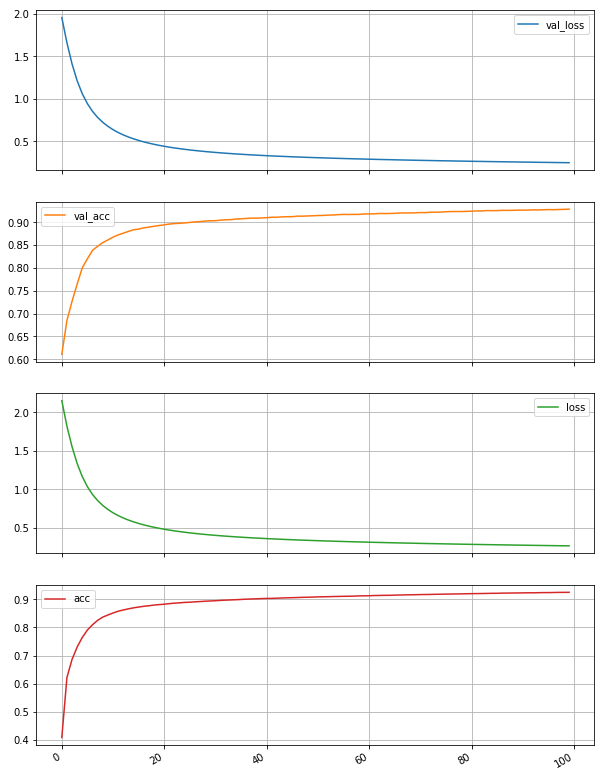

In [25]:
%matplotlib inline

df = pandas.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print('Deep Neural Network | MNIST')
print('Accuracy:',accuracy_NN)
print('Loss:',loss_NN)

In [28]:
y_pred = model.predict(X_test_NN)
print(metrics.confusion_matrix(y_test_NN.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 958    0    2    1    0    4   10    1    4    0]
 [   0 1110    3    2    0    1    4    2   13    0]
 [  13    6  932    8   10    1   13   12   33    4]
 [   3    1   17  931    0   23    2   11   18    4]
 [   1    2    5    1  922    0   12    2    6   31]
 [   8    3    4   39    5  785   15    4   23    6]
 [  10    3    4    0   13   14  910    1    3    0]
 [   4    9   27    6    8    0    0  949    2   23]
 [   6    7    6   20    8   18   10   13  881    5]
 [  14    7    1   12   36    7    1   21    4  906]]


### USPS Data Performance

In [29]:
lossUSPS_NN,accuracyUSPS_NN = model.evaluate(X_USPS_NN, y_USPS_NN)
print('Deep Neural Network | USPS')
print('Accuracy USPS:',accuracyUSPS_NN)
print('Loss USPS:',lossUSPS_NN)
y_pred_USPS = model.predict(X_USPS_NN)
print(metrics.confusion_matrix(y_USPS_NN.argmax(axis=1), y_pred_USPS.argmax(axis=1)))

19999/19999 [==============================] - 0s 12us/step
Deep Neural Network | USPS
Accuracy USPS: 0.384869243453232
Loss USPS: 2.546163725920919
[[ 530    2  256   78  242  192   63   74  132  431]
 [ 130  365  203  237  144  116   23  597  148   37]
 [ 181   18 1285  105   57  156   58   69   52   18]
 [  66    4  145 1358   11  267   10   67   45   27]
 [  24   50   43   36 1088  157   23  177  231  171]
 [ 110   10  202  179   39 1232   84   65   60   19]
 [ 304    7  386   58   87  297  774   15   23   49]
 [  94  174  285  518   40  195   14  450  164   66]
 [ 177   24  165  231  105  651  106   59  407   75]
 [  27  130  122  500  141   96    6  471  299  208]]


# Convolutional Neural Network

In [10]:
CNNmodel = Sequential()
batch_size = 128
epochs=12
dim = 28
#Data preprocessing
X_train_CNN = X_train.reshape(X_train.shape[0],1,dim,dim)
X_test_CNN = X_test.reshape(X_test.shape[0],1,dim,dim)
X_val_CNN = X_val.reshape(X_test.shape[0],1,dim,dim)

print(X_train_CNN.shape)

(50000, 1, 28, 28)


In [12]:
#In →  [Conv2D → relu]*2 → MaxPool2D → Dropout(0.25)  → Flatten → Dense → relu → Dropout (0.5) → Softmax→ Out
cnnModel = Sequential()
cnnModel.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,dim,dim),data_format='channels_first'))
cnnModel.add(Conv2D(64, (3, 3), activation='relu'))
cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
cnnModel.add(Dropout(0.25))
cnnModel.add(Flatten())
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(num_classes, activation='softmax'))

cnnModel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

historyCNN = cnnModel.fit(X_train_CNN, y_train_NN,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_CNN, y_val_NN))

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 97s 2ms/step - loss: 0.3388 - acc: 0.8949 - val_loss: 0.0848 - val_acc: 0.9764
Epoch 2/12
50000/50000 [==============================] - 98s 2ms/step - loss: 0.1036 - acc: 0.9693 - val_loss: 0.0568 - val_acc: 0.9832
Epoch 3/12
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0766 - acc: 0.9777 - val_loss: 0.0484 - val_acc: 0.9858
Epoch 4/12
50000/50000 [==============================] - 98s 2ms/step - loss: 0.0598 - acc: 0.9823 - val_loss: 0.0451 - val_acc: 0.9868
Epoch 5/12
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0501 - acc: 0.9845 - val_loss: 0.0463 - val_acc: 0.9865
Epoch 6/12
50000/50000 [==============================] - 99s 2ms/step - loss: 0.0434 - acc: 0.9864 - val_loss: 0.0410 - val_acc: 0.9893
Epoch 7/12
50000/50000 [==============================] - 98s 2ms/step - loss: 0.0385 - acc: 0.9884 - val_loss: 0.0398 - val_acc

### MNIST Data Performance

Convolutional Neural Network | MNIST
Accuracy: 0.9917
Loss: 0.027809406253465205


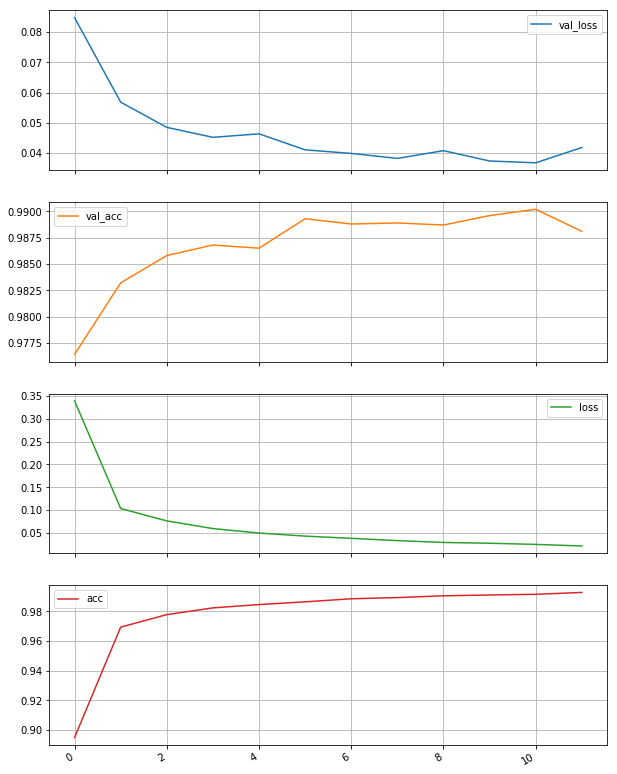

In [16]:
loss_CNN,accuracy_CNN = cnnModel.evaluate(X_test_CNN, y_test_NN, verbose=0)

%matplotlib inline

df = pandas.DataFrame(historyCNN.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
print('Convolutional Neural Network | MNIST')
print('Accuracy:',accuracy_CNN)
print('Loss:', loss_CNN)

In [14]:
y_pred_CNN = cnnModel.predict(X_test_CNN)
print(metrics.confusion_matrix(y_test_NN.argmax(axis=1), y_pred_CNN.argmax(axis=1)))

[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1132    1    0    0    0    1    0    1    0]
 [   1    1 1023    0    2    0    0    3    1    1]
 [   0    0    3  999    0    3    0    0    2    3]
 [   0    0    0    0  979    0    0    0    0    3]
 [   1    0    0    4    0  879    5    2    0    1]
 [   3    2    0    0    2    1  949    0    1    0]
 [   0    2    7    1    0    0    0 1016    0    2]
 [   4    0    2    0    0    0    0    0  965    3]
 [   0    0    0    1    7    0    0    3    0  998]]


### USPS Data Performance

In [17]:
X_USPS_CNN = USPSMat.reshape(USPSMat.shape[0],1,dim,dim)
lossUSPS_CNN,accuracyUSPS_CNN = cnnModel.evaluate(X_USPS_CNN, y_USPS_NN)
print('Convolutional Neural Network | USPS')
print('Accuracy USPS:',accuracyUSPS_CNN)
print('Loss USPS:',lossUSPS_CNN)
y_pred_USPS_CNN = cnnModel.predict(X_USPS_CNN)
print(metrics.confusion_matrix(y_USPS_NN.argmax(axis=1), y_pred_USPS_CNN.argmax(axis=1)))

19999/19999 [==============================] - 17s 872us/step
Convolutional Neural Network | USPS
Accuracy USPS: 0.6004300214876633
Loss USPS: 2.6429732614987804
[[ 869    1  202   15  193   11   55    7  260  387]
 [   9  755  583   65  143   20   39  358   20    8]
 [  32    5 1802   46   11   51   18   14   14    6]
 [   2    1   96 1666    7  206    5    6   10    1]
 [   1   32   61    5 1347   12   58  199  265   20]
 [  13    0   60   48   13 1774    7   26   38   21]
 [  47   11  114    4   61   26 1710    1   20    6]
 [  11   77 1033  133   17   10   55  575   87    2]
 [  32    7  147  175   44  421  101   33 1006   34]
 [   1   26  386  157  140   13    3  476  294  504]]


# Support Vector Machine

## Ideal HyperParameters 
### RBF Kernel | Gamma =0.01 | Penalty parameter C = 200 | Kernel cache size = 8000

In [30]:
# SVM
SVM = SVC(C=200,kernel='rbf',gamma=0.01,cache_size=8000,probability=False)
SVM.fit(X_train, y_train)

SVC(C=200, cache_size=8000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
SVM_predicted = SVM.predict(X_test)

### MNIST Data Performance

In [32]:
print('SVM | MNIST')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, SVM_predicted))
print('Accuracy:',metrics.accuracy_score(y_test,SVM_predicted))

SVM | MNIST
Confusion matrix:
[[ 973    0    2    1    0    1    1    0    2    0]
 [   0 1128    3    0    0    1    1    1    1    0]
 [   3    1 1016    0    1    0    1    7    3    0]
 [   0    0    1  993    0    3    0    4    6    3]
 [   1    0    3    0  967    0    2    0    0    9]
 [   3    0    0    9    1  870    4    0    3    2]
 [   5    2    1    0    2    4  943    0    1    0]
 [   0    7    8    2    0    0    0 1004    0    7]
 [   3    0    2    4    4    2    1    2  952    4]
 [   3    4    1    7   10    2    0    4    1  977]]
Accuracy: 0.9823


### USPS Data Performance

In [33]:
SVM_predicted_USPS = SVM.predict(USPSMat)
print('SVM | USPS')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, SVM_predicted_USPS))
print('Accuracy:',metrics.accuracy_score(USPSTar,SVM_predicted_USPS))

SVM | USPS
Confusion matrix:
[[ 652    1  485   40  128  291   39   93    0  271]
 [ 105  517  345  116   99  128   17  647   15   11]
 [  55   11 1681   56    9  128   18   36    4    1]
 [  22    3  234 1236    0  473    0   29    0    3]
 [  17   72  214   22  909  282    6  422   14   42]
 [  59    6  293   45    8 1544   14   25    5    1]
 [ 169    6  738   27   35  202  799    8    0   16]
 [  45  183  452  395   20  288    2  610    2    3]
 [  81    5  321  313   33 1031   32   40  137    7]
 [   9   82  328  383  113  144    2  690   89  160]]
Accuracy: 0.4122706135306765


## Linear Kernel

In [48]:
# SVM Linear Kernel
linearSVM = SVC(kernel='linear')
linearSVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [49]:
linearSVM_predicted = linearSVM.predict(X_test)

### MNIST Data Performance

In [53]:
print('SVM Linear Kernel | MNIST')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, linearSVM_predicted))
print('Accuracy:',metrics.accuracy_score(y_test,linearSVM_predicted))

SVM Linear Kernel | MNIST
Confusion matrix:
[[ 959    0    5    2    2    4    7    0    1    0]
 [   0 1121    3    3    0    1    2    1    4    0]
 [   6    8  968    9    3    2   11   10   13    2]
 [   5    2   17  944    4   13    1    8   13    3]
 [   2    1   10    1  943    0    4    2    2   17]
 [  13    4    2   39    5  792    9    1   22    5]
 [  10    3   11    1    5   14  911    2    1    0]
 [   1    8   20   10    6    1    0  961    3   18]
 [   8    4    9   25   11   27    6    5  871    8]
 [   7    6    2   13   32    4    0   18    7  920]]
Accuracy: 0.939


### USPS Data Performance

In [54]:
linearSVM_predicted_USPS = linearSVM.predict(USPSMat)
print('SVM Linear Kernel | USPS')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, linearSVM_predicted_USPS))
print('Accuracy:',metrics.accuracy_score(USPSTar,linearSVM_predicted_USPS))

SVM Linear Kernel | USPS
Confusion matrix:
[[ 348    0  476  152  222  345   74  172   10  201]
 [  60  303  534  275  230  172   17  351   37   21]
 [ 139   63 1293  115   33  221   55   45   21   14]
 [  56   58  341  898    8  520    9   45   48   17]
 [  24   24  221   82  800  215   10  464   82   78]
 [  47   25  652  240   41  876   30   35   41   13]
 [ 146   19  903   55   86  264  462   38    2   25]
 [  19   74  201  706   54  294   12  522   84   34]
 [ 100   16  298  449  126  692   82   58  160   19]
 [  18   38  204  588  142  104    8  580  155  163]]
Accuracy: 0.2912645632281614


## RBF Kernel | Gamma = 1

In [ ]:
SVM2 = SVC(kernel='rbf',gamma=1)
SVM2.fit(X_train, y_train)

In [ ]:
SVM2_predicted = SVM2.predict(X_test)

### MNIST Data Performance

In [ ]:
print('SVM | RBF Kernel | Gamma = 1 | MNIST')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, SVM2_predicted))
print('Accuracy:',metrics.accuracy_score(y_test,SVM2_predicted))

### USPS Data Performance

In [ ]:
SVM2_predicted_USPS = SVM2.predict(USPSMat)
print('SVM | RBF Kernel | Gamma = 1 | USPS')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, SVM2_predicted_USPS))
print('Accuracy:',metrics.accuracy_score(USPSTar,SVM2_predicted_USPS))

## RBF Kernel | Gamma = Default

In [18]:
SVM3 = SVC(kernel='rbf')
SVM3.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
SVM3_predicted = SVM3.predict(X_test)

### MNIST Data Performance

In [20]:
print('SVM | RBF Kernel | Gamma = Default | MNIST')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, SVM3_predicted))
print('Accuracy:',metrics.accuracy_score(y_test,SVM3_predicted))

SVM | RBF Kernel | Gamma = Default | MNIST
Confusion matrix:
[[ 967    0    1    0    0    5    4    1    2    0]
 [   0 1120    2    3    0    1    3    1    5    0]
 [   9    1  962    7   10    1   13   11   16    2]
 [   1    1   14  950    1   17    1   10   11    4]
 [   1    1    7    0  937    0    7    2    2   25]
 [   7    4    5   33    7  808   11    2   10    5]
 [  10    3    4    1    5   10  924    0    1    0]
 [   2   13   22    5    7    1    0  954    4   20]
 [   4    6    6   14    8   24   10    8  891    3]
 [  10    6    0   12   33    5    1   14    6  922]]
Accuracy: 0.9435


### USPS Data Performance

In [21]:
SVM3_predicted_USPS = SVM3.predict(USPSMat)
print('SVM | RBF Kernel | Gamma = Default | USPS')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, SVM3_predicted_USPS))
print('Accuracy:',metrics.accuracy_score(USPSTar,SVM3_predicted_USPS))

SVM | RBF Kernel | Gamma = Default | USPS
Confusion matrix:
[[ 573    2  428   19  285  248   73   44    6  322]
 [ 110  429  285  137  273  180   46  501   22   17]
 [ 128   18 1402   59   39  198   61   57   23   14]
 [  76    3  186 1123   11  483    5   70   27   16]
 [  18   67   91   14 1167  267   22  194   69   91]
 [ 108   17  257  102   25 1367   60   43   15    6]
 [ 197    7  489   24   98  394  748   13    7   23]
 [  50  225  457  265   57  416   15  452   41   22]
 [  73   25  209  193   87 1006   95   41  244   27]
 [  26  166  228  278  213  165    8  499  214  203]]
Accuracy: 0.38541927096354817


# Random Forest Classifier

In [22]:
#RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=10)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
RFC_predicted = RFC.predict(X_test)

In [24]:
print('Random Forest | MNIST')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, RFC_predicted))
print('Accuracy:',metrics.accuracy_score(y_test,RFC_predicted))

Random Forest | MNIST
Confusion matrix:
[[ 968    0    1    2    0    3    5    1    0    0]
 [   0 1118    3    3    2    0    4    1    4    0]
 [  10    1  978    6    6    1    7   12   10    1]
 [   1    2   17  944    0   20    1    8   11    6]
 [   3    2    1    1  932    1   11    4    3   24]
 [   8    2    2   32    6  819    6    1    9    7]
 [   7    3    1    1    7   12  924    0    3    0]
 [   2    8   22    7    6    0    0  962    3   18]
 [   7    3   16   21    9   14    8    7  878   11]
 [   6    7    6   14   31    9    2    6    6  922]]
Accuracy: 0.9445


In [25]:
RFC_predicted_USPS = RFC.predict(USPSMat)
print('Random Forest | USPS')
print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, RFC_predicted_USPS))
print('Accuracy:',metrics.accuracy_score(USPSTar,RFC_predicted_USPS))

Random Forest | USPS
Confusion matrix:
[[640  44 272 109 369 210  77  95  14 170]
 [ 62 637 169  83 116  96  32 767  22  16]
 [209 131 957 173  67 194  40 185  24  19]
 [ 98  74 224 927 104 367  18 140  15  33]
 [ 47 273 110  91 874 160  33 330  33  49]
 [253  67 219 258  79 911  46 110  26  31]
 [434 109 311 112 164 272 468  97  13  20]
 [ 67 431 415 263  93 172  37 499   9  14]
 [150 130 252 249 165 684  96  97 130  47]
 [ 75 301 300 297 249 133  24 439  82 100]]
Accuracy: 0.3071653582679134


# Ensemble Classifier

In [91]:
ensemble = []
ensemble.append(y_pred.argmax(axis=1))
ensemble.append(y_pred_CNN.argmax(axis=1))
ensemble.append(SVM_predicted)
ensemble.append(linearSVM_predicted)
ensemble.append(SVM3_predicted)
ensemble.append(RFC_predicted)
ensemble.append(y_test_l.argmax(axis=1))
ensemble = np.array(ensemble)
#Majority voting
ensemble_pred,count = stats.mode(ensemble,axis=0)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_data[1], ensemble_pred.T))
print('Accuracy:',metrics.accuracy_score(test_data[1],ensemble_pred.T))

Confusion matrix:
[[ 972    0    0    1    0    2    3    1    1    0]
 [   0 1120    2    2    0    1    4    1    5    0]
 [   9    1  987    4    4    0    8   10    8    1]
 [   0    0   10  971    0   10    1    7    8    3]
 [   1    0    4    0  955    0    6    0    2   14]
 [   8    2    1   23    4  830    9    1    9    5]
 [   8    3    3    1    4    9  929    0    1    0]
 [   3    9   22    4    4    0    0  970    2   14]
 [   6    3    3   14    6   15    8    5  911    3]
 [  10    6    1   12   18    4    1    9    2  946]]
Accuracy: 0.9591


In [95]:
ensembleUSPS = []
ensembleUSPS.append(y_pred_USPS.argmax(axis=1))
ensembleUSPS.append(y_pred_USPS_CNN.argmax(axis=1))
ensembleUSPS.append(SVM_predicted_USPS)
ensembleUSPS.append(linearSVM_predicted_USPS)
ensembleUSPS.append(SVM3_predicted_USPS)
ensembleUSPS.append(RFC_predicted_USPS)
ensembleUSPS.append(y_USPS.argmax(axis=1))
ensembleUSPS = np.array(ensembleUSPS)
#Majority voting
ensemble_pred_USPS,count = stats.mode(ensembleUSPS,axis=0)

print("Confusion matrix:\n%s" % metrics.confusion_matrix(USPSTar, ensemble_pred_USPS.T))
print('Accuracy:',metrics.accuracy_score(USPSTar,ensemble_pred_USPS.T))

Confusion matrix:
[[ 655    2  419   44  262  192   53   41   28  304]
 [ 134  479  316  177  175  117   18  543   32    9]
 [ 136   17 1532   66   32  118   38   38   15    7]
 [  64    3  181 1359    4  315    3   45   17    9]
 [  21   78   95   26 1172  182   13  224  122   67]
 [ 107   12  263  116   23 1384   34   41   17    3]
 [ 269    8  521   36   78  255  797   11    5   20]
 [  80  215  446  413   43  245   13  474   59   12]
 [ 120   24  225  252   87  854   75   39  301   23]
 [  30  157  235  419  151  102    5  502  222  177]]
Accuracy: 0.4165208260413021
